In [1]:
%matplotlib inline

import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.linear_model
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn_pandas import DataFrameMapper
import warnings

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

In [2]:
import csv

with open('lending-club/accepted_2007_to_2017.csv') as loan_file:
    reader = csv.reader(loan_file)
    loan_header = reader.__next__()

with open('lending-club/rejected_2007_to_2017.csv') as reject_file:
    reader = csv.reader(reject_file)
    reject_header = reader.__next__()
    
print(loan_header)
print()
print(reject_header)

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 

In [3]:
with open('LoanStats_2017Q2.csv') as loan_file:
    with open ('LoanStats_2017Q2_first_1000.csv', 'w') as out_file:
        for _ in range(1000):
            out_file.write(loan_file.readline())
            
with open('RejectStats_2017Q2.csv') as reject_file:
    with open ('RejectStats_2017Q2_first_1000.csv', 'w') as out_file:
        for _ in range(1000):
            out_file.write(reject_file.readline())

In [4]:
HEADER_MAPPING = {'Amount Requested': 'loan_amnt',
                  # funded_amnt = 0
                 'Application Date': 'issue_d', # clean up date formats
                  # Loan title needs to be cleaned up into purpose
                  'Debt-To-Income Ratio': 'dti', # remove % in rejected
                  'Employment Length': 'emp_length', # also requires cleanup
                  'Zip Code': 'zip_code',
                  'State': 'addr_state'
                 }

## Load the data, picking only the fields we need

In [5]:
ACCEPTED_FIELDS = ('loan_amnt', 'emp_length', 'issue_d', 'purpose', 
                    'zip_code', 'addr_state', 'dti', 'funded_amnt')
REJECTED_FIELDS = ('Amount Requested', 'Employment Length', 'Application Date', 
                   'Loan Title', 'Zip Code', 'State', 'Debt-To-Income Ratio')

ACCEPTED_FILE = 'LoanStats_2007_2011.csv'
REJECTED_FILE = 'RejectStats_2007_2012.csv'

accepted_data = pandas.read_csv(ACCEPTED_FILE, skiprows=0, header=1, usecols=ACCEPTED_FIELDS)
rejected_data = pandas.read_csv(REJECTED_FILE, skiprows=0, header=1, usecols=REJECTED_FIELDS)


## Transform rejected data to match accepted
- Added funded amount column
- Remove % in rejected debt-to-income
- Clean up employment length

In [6]:
rejected_data['funded_amnt'] = 0
rejected_data['accepted'] = 0
accepted_data['accepted'] = 1

rejected_data['Debt-To-Income Ratio'].replace('%', '', regex=True, inplace=True)
rejected_data['Debt-To-Income Ratio'] = pandas.to_numeric(rejected_data['Debt-To-Income Ratio'])

rejected_data['Employment Length'].replace('\D', '', regex=True, inplace=True)
rejected_data['Employment Length'] = pandas.to_numeric(rejected_data['Employment Length'])

accepted_data['emp_length'].replace('\D', '', regex=True, inplace=True)
accepted_data['emp_length'] = pandas.to_numeric(accepted_data['emp_length'])

rejected_data['Application Date'] = pandas.to_datetime(rejected_data['Application Date'])
accepted_data['issue_d'] = pandas.to_datetime(accepted_data['issue_d'], format='%b-%Y')

In [7]:
existing_purposes = set(accepted_data.purpose)
rejected_data['Loan Title'] = rejected_data['Loan Title'].str.lower().replace('\s+', '_', regex=True) 
sum([title in existing_purposes for title in rejected_data['Loan Title']]) / len(rejected_data['Loan Title'])

0.842062976263119

Since ~84% (in the 2007-2012 data) have a title that matches existing ones in the accepted data, I'll simply rename the other ones to 'other'

In [8]:
rejected_data.loc[[title not in existing_purposes for title in rejected_data['Loan Title']], 'Loan Title'] = 'other'

In [9]:
print(accepted_data.zip_code.isnull().sum() / len(accepted_data))
print(rejected_data['Zip Code'].isnull().sum() / len(rejected_data))

print(accepted_data.addr_state.isnull().sum() / len(accepted_data))
print(rejected_data['State'].isnull().sum() / len(rejected_data))

print(accepted_data.emp_length.isnull().sum() / len(accepted_data))
print(rejected_data['Employment Length'].isnull().sum() / len(rejected_data))

print(accepted_data.purpose.isnull().sum() / len(accepted_data))
print(rejected_data['Loan Title'].isnull().sum() / len(rejected_data))

7.05251774884e-05
2.91201351174e-05
7.05251774884e-05
2.77964926121e-05
0.0262118576332
0.0107612135684
7.05251774884e-05
7.94185503203e-06


Since there are almost no nulls, we can safely omit them for zip code and state address, but for the employment length, we'll simply treat them as 0's (and for purpose, as 'other'):

In [10]:
accepted_data = accepted_data.dropna(axis=0, subset=('zip_code', 'addr_state'), how='any')
rejected_data = rejected_data.dropna(axis=0, subset=('Zip Code', 'State'), how='any')

accepted_data = accepted_data.fillna({'emp_length': 0, 'purpose': 'other'})
rejected_data = rejected_data.fillna({'Employment Length': 0, 'Loan Title': 'other'})

In [11]:
acceted_cols_with_accepted = list(ACCEPTED_FIELDS) + ['accepted']

accepted_data = accepted_data[acceted_cols_with_accepted]
rejected_data = rejected_data[list(REJECTED_FIELDS) + ['funded_amnt', 'accepted']]
rejected_data.columns = acceted_cols_with_accepted

merged_data = pandas.concat((accepted_data, rejected_data), ignore_index=True)

In [12]:
merged_data.head()

,loan_amnt,emp_length,issue_d,purpose,zip_code,addr_state,dti,funded_amnt,accepted
0,5000.0,10.0,2011-12-01,credit_card,860xx,AZ,27.65,5000.0,1
1,2500.0,1.0,2011-12-01,car,309xx,GA,1.00,2500.0,1
2,2400.0,10.0,2011-12-01,small_business,606xx,IL,8.72,2400.0,1
3,10000.0,10.0,2011-12-01,other,917xx,CA,20.00,10000.0,1
4,3000.0,1.0,2011-12-01,other,972xx,OR,17.94,3000.0,1


In [13]:
merged_data.tail()

,loan_amnt,emp_length,issue_d,purpose,zip_code,addr_state,dti,funded_amnt,accepted
797999,35000.0,1.0,2012-12-31,other,342xx,FL,20.29,0.0,0
798000,3000.0,1.0,2012-12-31,other,021xx,MA,6.75,0.0,0
798001,10000.0,1.0,2012-12-31,debt_consolidation,828xx,WY,20.03,0.0,0
798002,25000.0,1.0,2012-12-31,debt_consolidation,336xx,FL,44.59,0.0,0
798003,35000.0,1.0,2012-12-31,other,211xx,MD,4.13,0.0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a571a90>]], dtype=object)

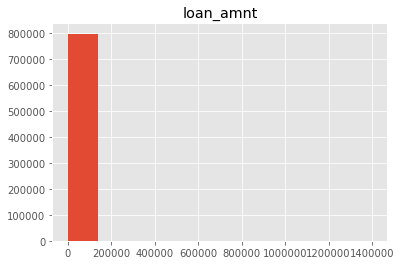

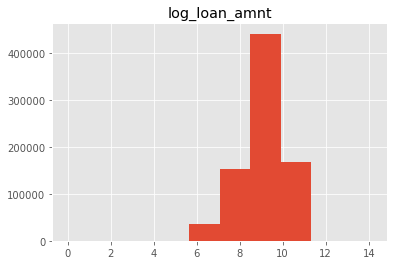

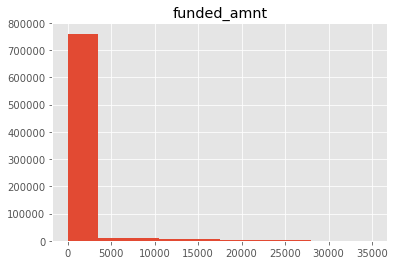

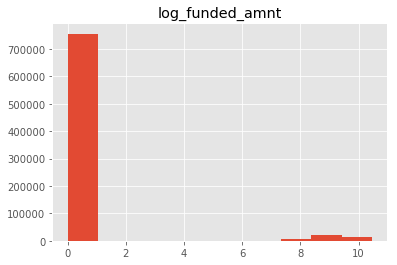

In [14]:
merged_data.hist('loan_amnt')
merged_data['log_loan_amnt'] = np.log(merged_data.loan_amnt + 1)
merged_data.hist(column='log_loan_amnt')

merged_data.hist('funded_amnt')
merged_data['log_funded_amnt'] = np.log(merged_data.funded_amnt + 1)
merged_data.hist(column='log_funded_amnt')

## Split data into train and test, balancing on accepted or not

In [15]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(merged_data, train_size=0.2, test_size=0.05, random_state=RANDOM_SEED,
                               stratify=merged_data.accepted) 
train.shape, test.shape

((159600, 11), (39901, 11))

## Define the mapper from pandas to something sklearn-friendly

In [16]:
from datetime import date, datetime
from sklearn.base import TransformerMixin

class DateToOrdinal(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        out = np.array([datetime.strptime(str(x.astype('M8[D]')), '%Y-%m-%d').date().toordinal() for x in X])
        return out.reshape((-1, 1))

data_mapper = DataFrameMapper([
    (['log_loan_amnt'], sklearn.preprocessing.StandardScaler()),
    (['emp_length'], sklearn.preprocessing.StandardScaler()),
    ('issue_d', [DateToOrdinal(), sklearn.preprocessing.StandardScaler()]),
    ('purpose', sklearn.preprocessing.LabelBinarizer()),
    ('zip_code', sklearn.preprocessing.LabelBinarizer()),
    ('addr_state', sklearn.preprocessing.LabelBinarizer()),
    (['dti'], sklearn.preprocessing.StandardScaler()),
])

transformed_data = data_mapper.fit_transform(train.copy())
print(transformed_data.shape)
# print(data_mapper.transformed_names_)
# transformed_data[:5]

/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


(159600, 996)


***
# First approach: regress funded_amnt
***

## Trying a ridge regression model, without feature selection

In [17]:
from sklearn.cross_validation import cross_val_score

np.random.seed(RANDOM_SEED)

pipe = sklearn.pipeline.Pipeline([
    ('featurize', data_mapper),
    ('ridge_reg', sklearn.linear_model.RidgeCV())])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shuffled = train.sample(frac=1)
    cv_scores = np.round(cross_val_score(pipe, X=shuffled, y=shuffled.log_funded_amnt, 
                                         scoring='r2', cv=3), 3)
    print(np.average(cv_scores), cv_scores)

/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.0926666666667 [ 0.025  0.123  0.13 ]


## Trying a ridge regression model with feature selection

In [18]:
from sklearn.cross_validation import cross_val_score

np.random.seed(RANDOM_SEED)

pipe = sklearn.pipeline.Pipeline([
    ('featurize', data_mapper),
    ('select', sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression)),
    ('ridge_reg', sklearn.linear_model.RidgeCV())])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for k in range(10, 17):
        pipe.set_params(select__k=k)
        shuffled = train.sample(frac=1)
        cv_scores = np.round(cross_val_score(pipe, X=shuffled, y=shuffled.log_funded_amnt, 
                                             scoring='mean_squared_error', cv=5), 3)
        print (k, np.average(cv_scores), cv_scores)

10 -3.6466 [-3.578 -3.727 -3.591 -3.612 -3.725]
11 -3.643 [-3.742 -3.604 -3.718 -3.546 -3.605]
12 -3.6426 [-3.62  -3.691 -3.764 -3.536 -3.602]
13 -3.6408 [-3.62  -3.631 -3.713 -3.664 -3.576]
14 -3.7862 [-3.693 -3.592 -3.601 -3.683 -4.362]
15 -3.8008 [-4.507 -3.69  -3.654 -3.527 -3.626]
16 -3.7782 [-3.681 -3.641 -3.594 -4.405 -3.57 ]


In [19]:
from sklearn import metrics

optimal_k = 13
pipe.set_params(select__k=optimal_k)
shuffled = train.sample(frac=1)
pipe.fit(shuffled, shuffled.log_funded_amnt)

# test_predictions = pipe.predict(test)

# for metric in (metrics.mean_squared_error, metrics.mean_absolute_error, 
#                metrics.median_absolute_error, metrics.r2_score): 
#     print(metric.__name__, metric(test_predictions, test.log_funded_amnt))

/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Pipeline(steps=[('featurize', DataFrameMapper(default=False, df_out=False,
        features=[(['log_loan_amnt'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['emp_length'], StandardScaler(copy=True, with_mean=True, with_std=True)), ('issue_d', [<__main__.DateToOrdinal object at 0x1181dea20>, ...None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False))])

In [20]:
k_best = pipe.steps[1][1]
names = np.ma.array(data_mapper.transformed_names_, mask=np.logical_not(k_best.get_support()))
# print(names.compressed())
# print(pipe.steps[2][1].coef_)

for column, coef in zip(names.compressed(), pipe.steps[2][1].coef_):
    print(column, ':', coef)

log_loan_amnt : -0.0645944387594
emp_length : 0.579012401664
issue_d : -0.319433146202
purpose_car : -0.410736127185
purpose_credit_card : 0.422289855688
purpose_debt_consolidation : 0.189603374946
purpose_educational : 0.128187107254
purpose_home_improvement : 0.108579117727
purpose_moving : -0.167197688694
purpose_other : -0.923961751828
zip_code_100xx : 0.588752714128
zip_code_941xx : 0.649136267633
addr_state_CA : 0.129910729003


The above is something of a post-hoc justification for ignoring the geographical fields - out of 1000 potential zipcodes and 50 potential states, only two zipcodes and one state were chosen to be used in the model.

## Treating the location data (state and zipcode) as noise
Since it generates a ~1000 feature matrix we cannot feasibly do anything interesting with. 
Instead, let's try to generate interaction terms between some of the potentially more meaningful features.

In [21]:
data_mapper_no_location = DataFrameMapper([
    (['log_loan_amnt'], sklearn.preprocessing.StandardScaler()),
    (['emp_length'], sklearn.preprocessing.StandardScaler()),
    ('issue_d', DateToOrdinal()),
    ('purpose', sklearn.preprocessing.LabelBinarizer()),
    (['dti'], sklearn.preprocessing.StandardScaler()),
])

transformed_data = data_mapper_no_location.fit_transform(train.copy())
print(data_mapper_no_location.transformed_names_)
print(transformed_data.shape)

['log_loan_amnt', 'emp_length', 'issue_d', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'dti']
(159600, 18)


In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import uniform

np.random.seed(RANDOM_SEED)

ridge_search_pipe = sklearn.pipeline.Pipeline([
    ('featurize', data_mapper_no_location),
    ('interactions', PolynomialFeatures(interaction_only=True)),
    ('ridge_reg', sklearn.linear_model.Ridge())
])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shuffled = train.sample(frac=1)
    cv_scores = np.round(cross_val_score(ridge_search_pipe, X=shuffled, y=shuffled.log_funded_amnt, 
                                         scoring='r2', cv=3), 3)
    print(np.average(cv_scores), cv_scores)
    


0.202333333333 [ 0.183  0.202  0.222]


In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import uniform

np.random.seed(RANDOM_SEED)

ridge_search_pipe = sklearn.pipeline.Pipeline([
    ('featurize', data_mapper_no_location),
    ('interactions', PolynomialFeatures(interaction_only=True)),
    ('select', sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression)),
    ('ridge_reg', sklearn.linear_model.Ridge())
])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for k in range(20, 40):
        ridge_search_pipe.set_params(select__k=k)
        shuffled = train.sample(frac=1)
        cv_scores = np.round(cross_val_score(ridge_search_pipe, X=shuffled, y=shuffled.log_funded_amnt, 
                                             scoring='mean_squared_error', cv=5), 3)
        print (k, np.average(cv_scores), cv_scores)
    


20 -3.314 [-3.26  -3.401 -3.263 -3.275 -3.371]
21 -3.3082 [-3.397 -3.281 -3.394 -3.165 -3.304]
22 -3.3068 [-3.261 -3.351 -3.406 -3.231 -3.285]
23 -3.304 [-3.285 -3.308 -3.346 -3.318 -3.263]
24 -3.302 [-3.321 -3.229 -3.291 -3.334 -3.335]
25 -3.3016 [-3.369 -3.347 -3.296 -3.206 -3.29 ]
26 -3.2942 [-3.329 -3.297 -3.23  -3.355 -3.26 ]
27 -3.2942 [-3.318 -3.182 -3.278 -3.359 -3.334]
28 -3.2936 [-3.254 -3.36  -3.337 -3.35  -3.167]
29 -3.2928 [-3.384 -3.245 -3.284 -3.333 -3.218]
30 -3.2912 [-3.298 -3.262 -3.296 -3.262 -3.338]
31 -3.2928 [-3.201 -3.276 -3.379 -3.321 -3.287]
32 -3.2926 [-3.441 -3.256 -3.286 -3.268 -3.212]
33 -3.2916 [-3.362 -3.254 -3.307 -3.171 -3.364]
34 -3.348 [-3.326 -3.238 -3.296 -3.327 -3.553]
35 -3.2894 [-3.347 -3.247 -3.164 -3.348 -3.341]
36 -3.3476 [-3.256 -3.233 -3.557 -3.341 -3.351]
37 -3.3356 [-3.235 -3.237 -3.291 -3.555 -3.36 ]
38 -3.3396 [-3.676 -3.204 -3.291 -3.218 -3.309]
39 -3.3362 [-3.283 -3.248 -3.575 -3.353 -3.222]


## Fit a model on the entire training set with k = 33, evaluate on test

In [24]:
from sklearn import metrics

optimal_k = 33
ridge_search_pipe.set_params(select__k=optimal_k)
shuffled = train.sample(frac=1)
ridge_search_pipe.fit(shuffled, shuffled.log_funded_amnt)

test_predictions = ridge_search_pipe.predict(test)

for metric in (metrics.mean_squared_error, metrics.mean_absolute_error, 
               metrics.median_absolute_error, metrics.r2_score): 
    print(metric.__name__, metric(test_predictions, test.log_funded_amnt))

/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/Users/guydavidson/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/guydavidson/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/guydavidson/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


mean_squared_error 3.29083284041
mean_absolute_error 0.77018932702
median_absolute_error 0.290925040961
r2_score -2.84796257301


In [25]:
k_best = ridge_search_pipe.steps[2][1]
interactions = ridge_search_pipe.steps[1][1]

names = np.ma.array(interactions.get_feature_names(), mask=np.logical_not(k_best.get_support()))
# print(names.compressed())
# print(pipe.steps[2][1].coef_)

# Ugly, but it will work
name_mapping = {'x{i}'.format(i=i) : data_mapper_no_location.transformed_names_[i] 
                for i in range(len(data_mapper_no_location.transformed_names_))}

compressed_names = [str(x) for x in names.compressed()]

for i in range(len(data_mapper_no_location.transformed_names_), 0, -1):
    name = 'x{i}'.format(i=i - 1) 
    compressed_names = [x.replace(name, name_mapping[name]) for x in compressed_names]
    
compressed_names = [x.replace(' ', ' XXX ') for x in compressed_names]

for column, coef in zip(compressed_names, ridge_search_pipe.steps[3][1].coef_):
    print(column, ':', coef)

log_loan_amnt : 3.97459613447
emp_length : -6.0908203264
issue_d : -0.000621822098793
purpose_car : 0.501664317345
purpose_credit_card : 1.34638333532
purpose_debt_consolidation : 6.39079049789
purpose_educational : 0.200367374703
purpose_home_improvement : 1.10385908914
purpose_other : -10.6716651213
log_loan_amnt XXX emp_length : -0.103826921142
log_loan_amnt XXX issue_d : -5.51609766583e-06
log_loan_amnt XXX purpose_other : 0.108607421343
emp_length XXX issue_d : 8.31832353827e-06
emp_length XXX purpose_car : 0.22955261631
emp_length XXX purpose_credit_card : 2.04634036056
emp_length XXX purpose_debt_consolidation : 1.10487222599
emp_length XXX purpose_educational : 0.735924153844
emp_length XXX purpose_home_improvement : 1.11460902129
emp_length XXX purpose_house : 1.59223957655
emp_length XXX purpose_major_purchase : 0.953282891593
emp_length XXX purpose_medical : 1.37901530367
emp_length XXX purpose_moving : 1.2873896443
emp_length XXX purpose_renewable_energy : 2.00206625327
emp

***
# Second approach: classify and examine
***

## Idea: attempt to classify whether or not a loan will be provided, then holding all else constant, play with loan amount and see what it means for the classifier
This is quite similar to (if not exactly the same as) what Skye suggested on the slack channel

In [26]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import uniform


np.random.seed(RANDOM_SEED)

ridge_classify_pipe = sklearn.pipeline.Pipeline([
    ('featurize', data_mapper_no_location),
    ('interactions', PolynomialFeatures(interaction_only=True)),
    ('select', sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression)),
    ('ridge', sklearn.linear_model.RidgeClassifierCV())
])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for k in range(20, 40):
        ridge_classify_pipe.set_params(select__k=k)
        shuffled = train.sample(frac=1)
        cv_scores = np.round(cross_val_score(ridge_classify_pipe, X=shuffled, y=shuffled.accepted, 
                                             scoring='f1', cv=3), 3)
        print (k, np.average(cv_scores), cv_scores)
    

20 0.118333333333 [ 0.042  0.042  0.271]
21 0.194 [ 0.271  0.042  0.269]
22 0.118666666667 [ 0.042  0.271  0.043]
23 0.115333333333 [ 0.041  0.041  0.264]
24 0.117 [ 0.042  0.039  0.27 ]
25 0.117666666667 [ 0.269  0.041  0.043]
26 0.118 [ 0.043  0.042  0.269]
27 0.042 [ 0.042  0.044  0.04 ]
28 0.116333333333 [ 0.266  0.042  0.041]
29 0.269666666667 [ 0.268  0.27   0.271]
30 0.116666666667 [ 0.041  0.267  0.042]
31 0.194333333333 [ 0.274  0.042  0.267]
32 0.0423333333333 [ 0.043  0.042  0.042]
33 0.192666666667 [ 0.271  0.041  0.266]
34 0.117 [ 0.042  0.268  0.041]
35 0.119 [ 0.043  0.272  0.042]
36 0.27 [ 0.269  0.273  0.268]
37 0.116666666667 [ 0.041  0.042  0.267]
38 0.196 [ 0.044  0.274  0.27 ]
39 0.193333333333 [ 0.267  0.042  0.271]


## Predicting on train to get scores for a few different metrics

In [27]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, mutual_info_score

optimal_k = 39
ridge_classify_pipe.set_params(select__k=optimal_k)
shuffled = train.sample(frac=1)
ridge_classify_pipe.fit(shuffled, shuffled.accepted)

train_predictions = ridge_classify_pipe.predict(train)

for metric in (classification_report, accuracy_score, roc_auc_score, mutual_info_score):
    print(metric.__name__)
    print(metric(train_predictions, train.accepted))

/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/Users/guydavidson/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/guydavidson/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/guydavidson/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


classification_report
             precision    recall  f1-score   support

          0       0.18      0.83      0.30     33587
          1       0.33      0.02      0.04    126013

avg / total       0.30      0.19      0.10    159600

accuracy_score
0.192593984962
roc_auc_score
0.426698280916
mutual_info_score
0.0276834197016


## As in previous problems, predicting the positive class appears much harder
let's try overweighing or oversampling it

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import uniform

np.random.seed(RANDOM_SEED)

ridge_classify_pipe = sklearn.pipeline.Pipeline([
    ('featurize', data_mapper_no_location),
    ('interactions', PolynomialFeatures(interaction_only=True)),
    ('select', sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression)),
    ('ridge', sklearn.linear_model.RidgeClassifierCV(class_weight={0: 1, 1: 10}))
])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for k in range(20, 30):
        ridge_classify_pipe.set_params(select__k=k)
        shuffled = train.sample(frac=1)
        cv_scores = np.round(cross_val_score(ridge_classify_pipe, X=shuffled, y=shuffled.accepted, 
                                             scoring='f1', cv=3), 3)
        print (k, np.average(cv_scores), cv_scores)
    

## Tragically, the following cell never actually runs on my computer - increasing the weights for some reason vastly increases the computational cost, to a point this won't actually converge.
Perhaps it might without the interaction features?

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import uniform

np.random.seed(RANDOM_SEED)

ridge_classify_pipe = sklearn.pipeline.Pipeline([
    ('featurize', data_mapper_no_location),
#     ('interactions', PolynomialFeatures(interaction_only=True)),
    ('select', sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression)),
    ('ridge', sklearn.linear_model.RidgeClassifierCV(class_weight='balanced'))
])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for k in range(3, 6):
        ridge_classify_pipe.set_params(select__k=k)
        shuffled = train.sample(frac=1)
        cv_scores = np.round(cross_val_score(ridge_classify_pipe, X=shuffled, y=shuffled.accepted, 
                                             scoring='f1', cv=3), 3)
        print (k, np.average(cv_scores), cv_scores)
    

## Nope, the above also crashes. Oh well, I'll write about it.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import uniform

np.random.seed(RANDOM_SEED)

ridge_search_classify_pipe = sklearn.pipeline.Pipeline([
    ('featurize', data_mapper_no_location),
    ('interactions', PolynomialFeatures(interaction_only=True)),
    ('select', sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression)),
    ('ridge', sklearn.linear_model.RidgeClassifierCV())
])

from collections import namedtuple
ClassWeightSampler = namedtuple('ClassWeightSampler', 'rvs')

def sample_class_weights(loc=0, scale=1, size=1, random_state=None):
    return {0: 1, 1: uniform.rvs(loc=1, scale=20, size=size, random_state=random_state)}

sampler = ClassWeightSampler(rvs=sample_class_weights)

# report function from http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    search_cv = RandomizedSearchCV(ridge_search_classify_pipe, n_iter=10, scoring='recall', n_jobs=1, 
                                   verbose=1, random_state=RANDOM_SEED,
                                   param_distributions={'ridge__class_weight': sampler,
                                                       })
    search_cv.fit(X=train, y=train.accepted)
    report(search_cv.cv_results_)